In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, ParameterGrid
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
import warnings
import time
warnings.filterwarnings("ignore")

In [93]:
data = pd.read_csv('../data/regional_univariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

In [94]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(actual,forecast): 
    actual, forecast = np.array(actual), np.array(forecast)
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

East North Central
21.938247203826904
MASE:  0.9665709235695714
SMAPE:  88.87367311870813
East South Central
23.68499779701233
MASE:  1.2568902782554978
SMAPE:  99.12622696398626
Mid-Atlantic
21.660633087158203
MASE:  2.14202189522061
SMAPE:  42.50872923725558
Mountain
23.934288024902344
MASE:  1.3039404236992942
SMAPE:  87.82607251976833
New England
23.544142723083496
MASE:  1.1104232079227283
SMAPE:  91.60175281877272
Pacific
22.044268131256104
MASE:  1.8407435729443986
SMAPE:  99.57376194570182
South Atlantic
22.4388210773468
MASE:  1.1728239135857361
SMAPE:  85.82078556832866
West North Central
22.180066108703613
MASE:  1.2144720107693003
SMAPE:  99.81387186137923
West South Central
19.95252299308777
MASE:  1.289552387405123
SMAPE:  71.31383649176684


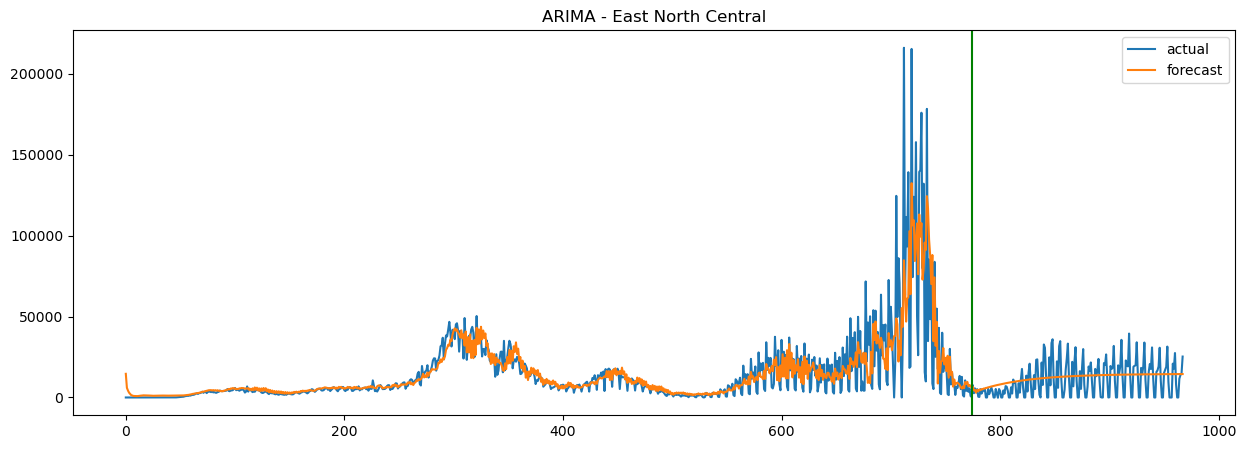

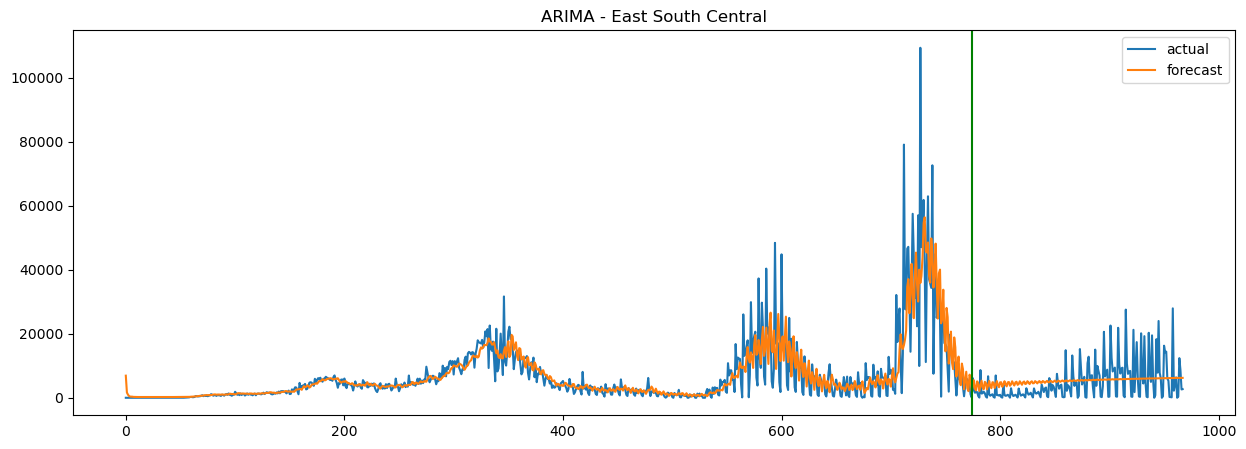

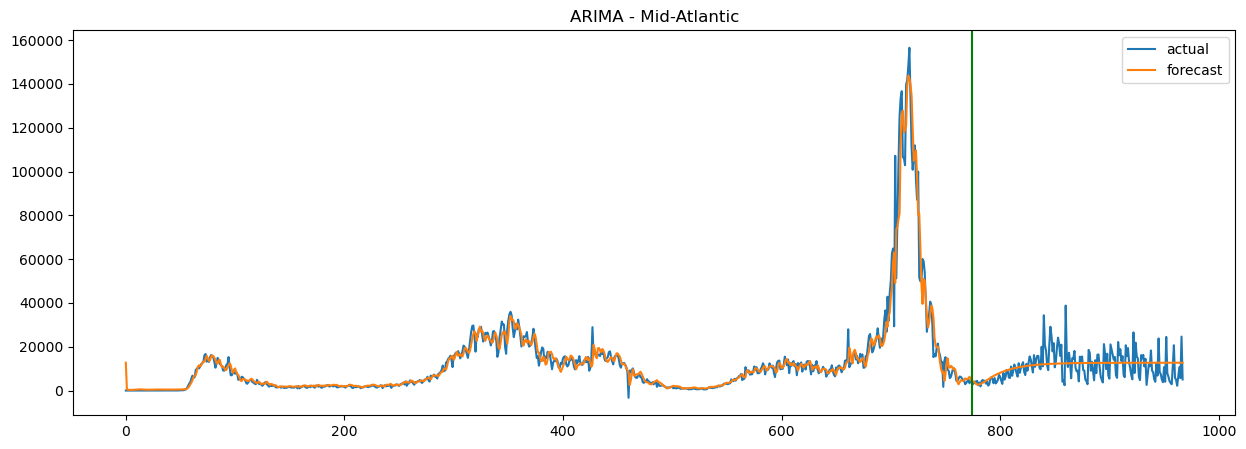

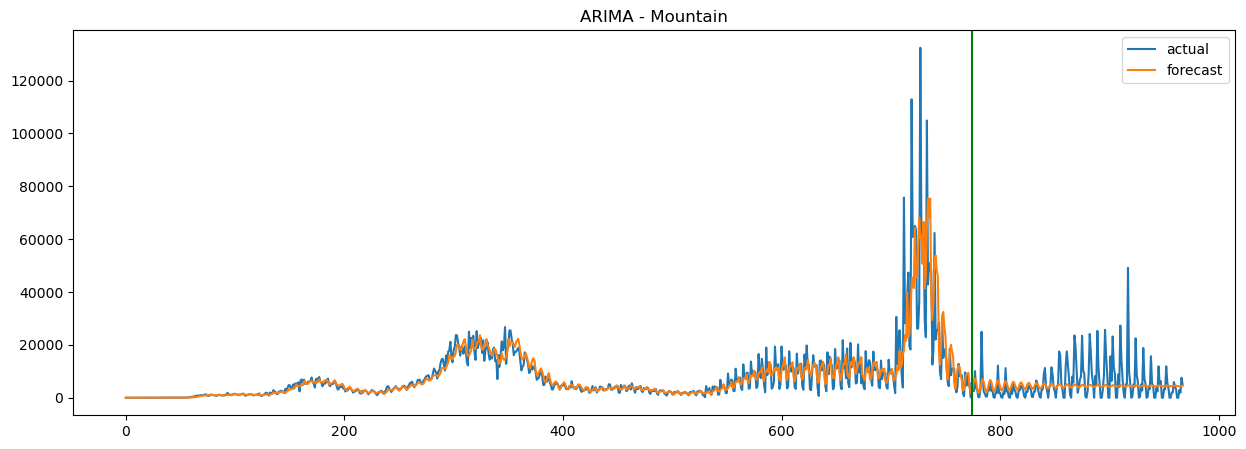

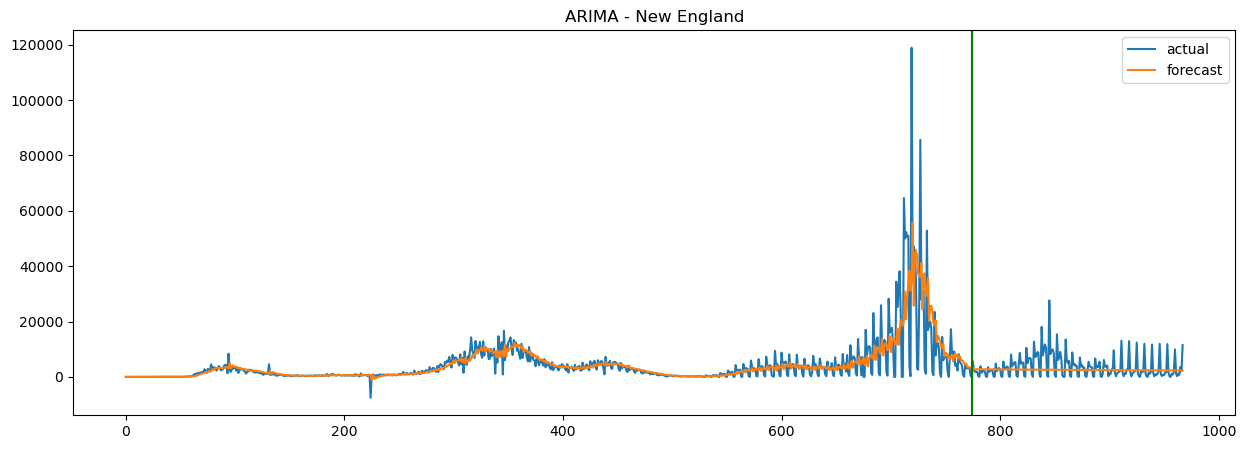

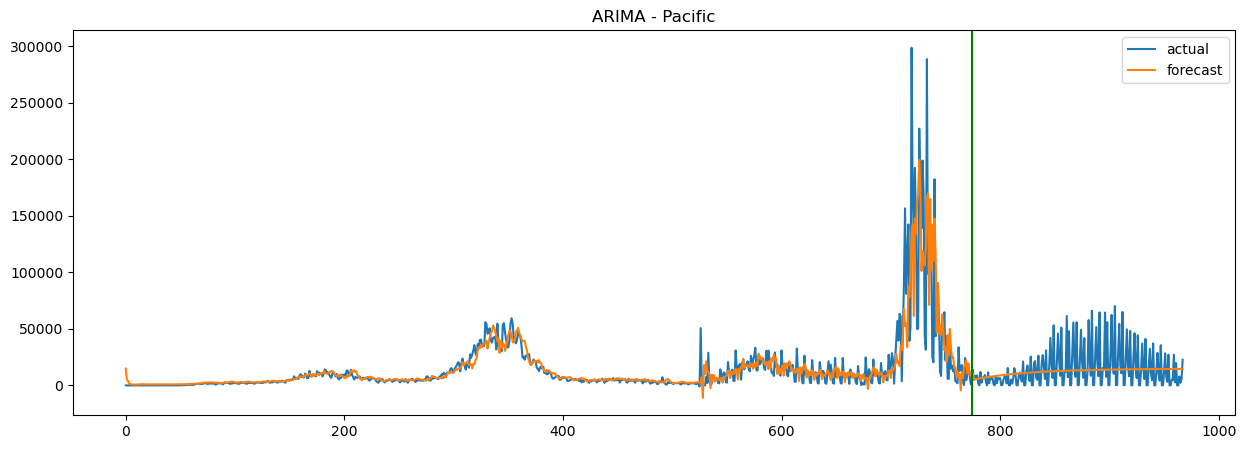

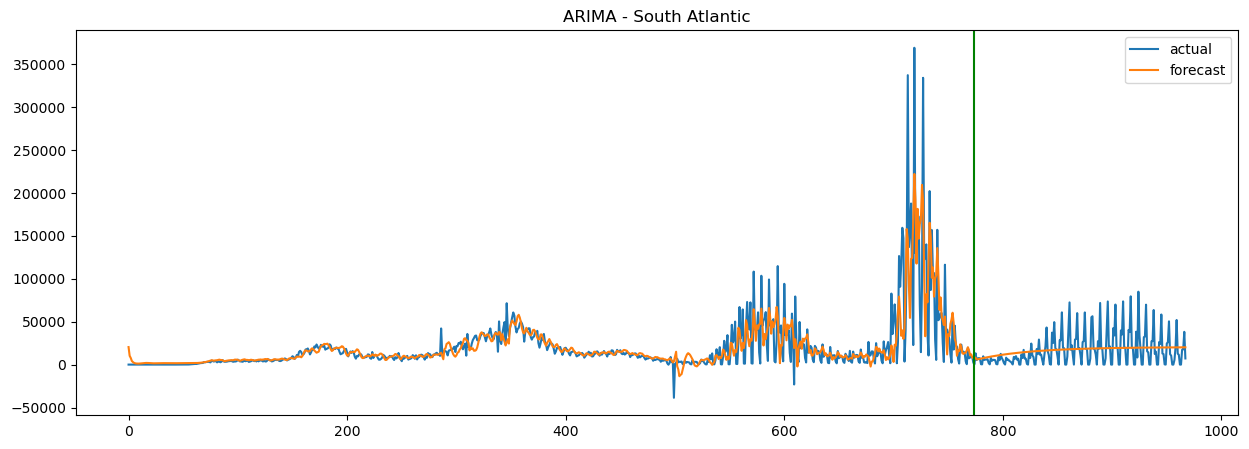

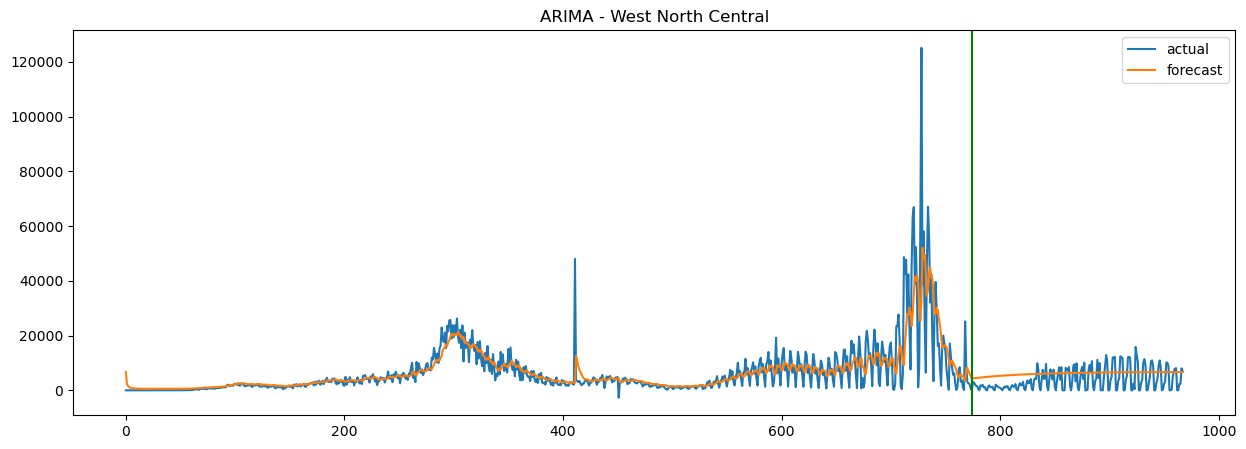

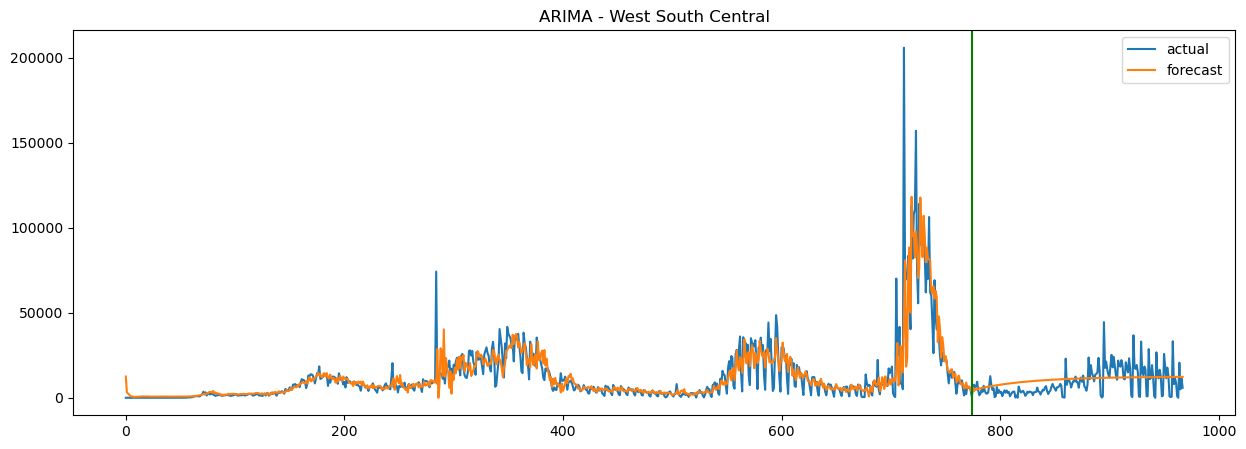

In [97]:
params_grid = {'p': [0,1,2,3,4,5],
               'd': [0,1,2],
               'q': [0,1,2,3,4,5]}
grid = ParameterGrid(params_grid)
best_params = []
best_params2 = []
best_smape = []
best_mase = []
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    start = time.time()
    print(data1.region.unique()[0])
    data = data1[['date', 'new_confirmed']].rename(columns = {'date': 'ds', 'new_confirmed': 'y'})
    size = round(data.shape[0]*0.2)
    train = data.iloc[:-size]
    test = data.iloc[-size:].reset_index().drop(columns = 'index')
    params = []
    smapes = []
    mases = []
    for param in grid:
        params.append(param)
        model = ARIMA(train.y, order = (param['p'], param['d'], param['q'])).fit()
        train_pred = model.fittedvalues
        test_pred = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
        smapetemp = smape(test.y, test_pred)
        smapes.append(smapetemp)
        masetemp = mean_absolute_scaled_error(test.y, test_pred, y_train = train.y)
        mases.append(masetemp)
    best_smape.append(min(smapes))
    best_params.append(params[np.argmin(smapes)])
    best_mase.append(min(mases))
    best_params2.append(params[np.argmin(mases)])
    best_model = ARIMA(train.y, order = (params[np.argmin(smapes)]['p'], 
                                         params[np.argmin(smapes)]['d'], 
                                         params[np.argmin(smapes)]['q'])).fit()
    pd.concat([(pd.concat([train, best_model.fittedvalues], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", 0: "forecast"}), 
           (pd.concat([test, best_model.forecast(len(test)).reset_index().drop(columns = 'index')], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", "predicted_mean": "forecast"})]
           ,axis = 0).reset_index().drop(columns = 'index').plot(figsize = (15,5))
    plt.title('ARIMA - ' + data1.region.unique()[0])
    plt.axvline(len(train), color = 'green')
    print(time.time() - start)
    print("MASE: ", mean_absolute_scaled_error(test.y, best_model.forecast(len(test)), y_train = train.y))
    print("SMAPE: ", smape(test.y, best_model.forecast(len(test))))

<Axes: >

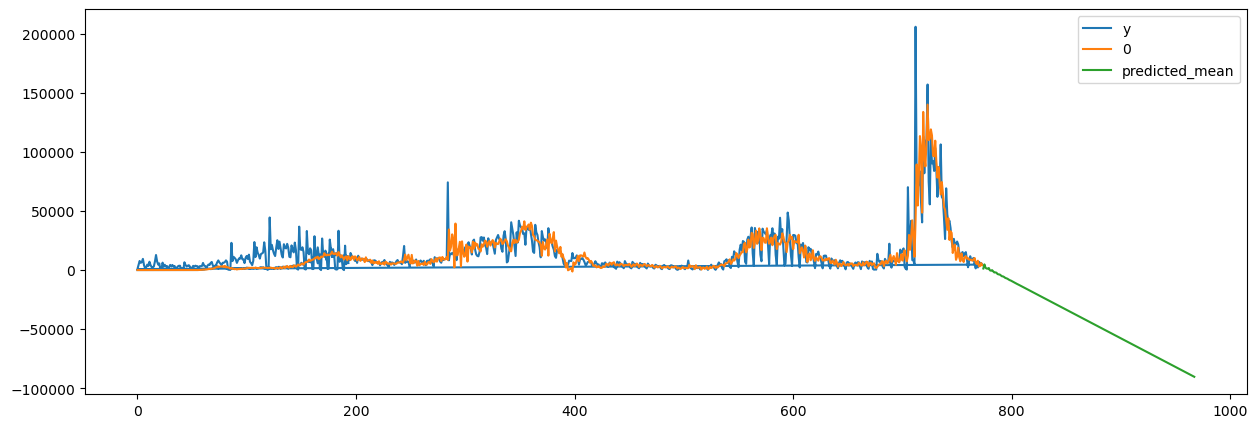

In [52]:
pd.concat([pd.concat([train, train_pred], axis = 1), pd.concat([test, test_pred], axis = 1)], axis = 0).plot(figsize = (15,5))

In [54]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  774
Model:                 ARIMA(5, 2, 5)   Log Likelihood               -8190.853
Date:                Wed, 21 Feb 2024   AIC                          16403.706
Time:                        20:10:42   BIC                          16454.845
Sample:                             0   HQIC                         16423.384
                                - 774                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4445      0.048    -29.869      0.000      -1.539      -1.350
ar.L2         -1.1817      0.089    -13.288      0.000      -1.356      -1.007
ar.L3         -0.5292      0.094     -5.641      0.000      -0.713      -0.345
ar.L4          0.1639      0.077      2.135      0.033       0.013       0.314
ar.L5          0.1952      0.050      3.942      0.000       0.098       0.292
ma.L1         -0.1709      0.050     -3.420      0.001      -0.269      -0.073
ma.L2         -0.6712      0.040    -16.677      0.000      -0.750      -0.592
ma.L3         -0.5257      0.064     -8.197      0.000      -0.651      -0.400
ma.L4         -0.0345      0.045     -0.761      0.447      -0.123       0.054
ma.L5          0.6615      0.043     15.252      0.000       0.576       0.747
sigma2      1.236e+08   2.52e-09    4.9e+16      0.000    1.24e+08    1.24e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):            422617.98
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):              67.98   Skew:                             6.55
Prob(H) (two-sided):                  0.00   Kurtosis:                       116.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.58e+32. Standard errors may be unstable.
"""

In [25]:
test_pred = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)